## Fase 1: Entendimento dos Dados (Data Understanding)

### 1.1: Análise Estrutural e Descobertas Chave (EDA)

#### Justificativa:

Antes de aplicar qualquer técnica de machine learning, é essencial entender os dados com os quais estamos trabalhando. A análise exploratória (EDA) nos permite identificar padrões, desafios e oportunidades nos dados, garantindo que as decisões subsequentes sejam baseadas em evidências sólidas.

#### Etapas:

Carregamento e inspeção inicial dos dados, verificando sua estrutura e qualidade.

Identificação de desbalanceamento nas classes (fraude x não fraude).

Análise do valor das transações, comparando transações normais e fraudulentas.

Visualização das distribuições e percentis para entender melhor os dados.

#### Benefícios:

Permite identificar que o problema de fraude é altamente desbalanceado, o que influencia diretamente a escolha de métricas e técnicas de modelagem.

Revela que transações fraudulentas tendem a ter valores menores, o que pode ser usado como uma característica preditiva.

Facilita a comunicação dos achados para equipes não técnicas, mostrando de forma clara os principais desafios e oportunidades.

### Importação das Bibliotecas E Configurações

In [1]:
# Célula 1: Imports e Configurações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

### Carregamento dos Dados

In [2]:
# Célula 2: Carregamento de Dados 
def load_data():
    """Carrega e retorna o dataset de fraudes"""
    import kagglehub
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    file_path = os.path.join(path, 'creditcard.csv')
    df = pd.read_csv(file_path)
    return df

# Carregar dados
df = load_data()
print(" Dataset carregado com sucesso!")
print(f" Dimensões: {df.shape}")
print(f" Variáveis: {df.columns.tolist()}")

 Dataset carregado com sucesso!
 Dimensões: (284807, 31)
 Variáveis: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


### Análise Exploratória

In [3]:
# Célula 3: Análise Exploratória 
def exploratory_analysis(df):
    """Realiza análise exploratória completa do dataset"""
    
    print("=" * 50)
    print("ANÁLISE EXPLORATÓRIA - FRAUDES")
    print("=" * 50)
    
    # 3.1 Estrutura básica
    print("\n **1. ESTRUTURA DO DATASET**")
    print(f"• Dimensões: {df.shape}")
    print(f"• Colunas: {len(df.columns)}")
    print(f"• Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # 3.2 Tipos de dados
    print("\n **2. TIPOS DE DADOS**")
    print(df.dtypes.value_counts())
    
    # 3.3 Análise de valores nulos
    print("\n **3. VALORES NULOS**")
    null_count = df.isnull().sum()
    null_pct = (df.isnull().sum() / len(df)) * 100
    null_info = pd.DataFrame({
        'Valores Nulos': null_count,
        'Percentual (%)': null_pct
    })
    print(null_info[null_info['Valores Nulos'] > 0])
    
    if null_info['Valores Nulos'].sum() == 0:
        print(" Nenhum valor nulo encontrado!")
    
    return None

# Executar análise
exploratory_analysis(df)

ANÁLISE EXPLORATÓRIA - FRAUDES

 **1. ESTRUTURA DO DATASET**
• Dimensões: (284807, 31)
• Colunas: 31
• Memória utilizada: 67.36 MB

 **2. TIPOS DE DADOS**
float64    30
int64       1
Name: count, dtype: int64

 **3. VALORES NULOS**
Empty DataFrame
Columns: [Valores Nulos, Percentual (%)]
Index: []
 Nenhum valor nulo encontrado!


### Análise de Desbalanceamento Detalhada

ANÁLISE DE DESBALANCEAMENTO DE CLASSES

 **DISTRIBUIÇÃO DAS CLASSES:**
• Classe 0 (NORMAL): 284,315 transações (99.8273%)
• Classe 1 (FRAUDE): 492 transações (0.1727%)


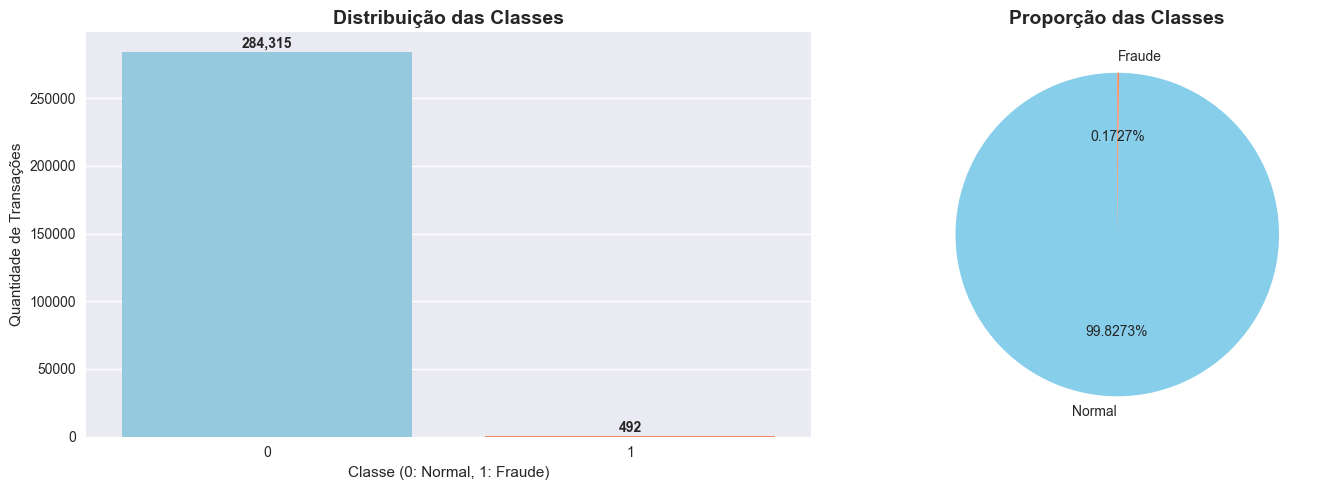


 **TAXA DE DESBALANCEAMENTO:** 577.88:1
 **IMPLICAÇÃO:** Modelo 'ingênuo' que sempre prevê 'Não Fraude' teria acurácia de 99.83%!


In [4]:
# Célula 4: Análise de Desbalanceamento Detalhada
def analyze_class_balance(df):
    """Analisa o desbalanceamento entre classes"""
    
    print("=" * 50)
    print("ANÁLISE DE DESBALANCEAMENTO DE CLASSES")
    print("=" * 50)
    
    # Contagem e proporções
    class_counts = df['Class'].value_counts()
    class_proportions = df['Class'].value_counts(normalize=True) * 100
    
    print("\n **DISTRIBUIÇÃO DAS CLASSES:**")
    for classe, count in class_counts.items():
        proporcao = class_proportions[classe]
        tipo = "FRAUDE" if classe == 1 else "NORMAL"
        print(f"• Classe {classe} ({tipo}): {count:,} transações ({proporcao:.4f}%)")
    
    # Plotar distribuição
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de barras
    sns.countplot(data=df, x='Class', ax=ax1, palette=['skyblue', 'coral'])
    ax1.set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Classe (0: Normal, 1: Fraude)')
    ax1.set_ylabel('Quantidade de Transações')
    
    # Adicionar valores nas barras
    for i, count in enumerate(class_counts):
        ax1.text(i, count + 1000, f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico de pizza
    colors = ['skyblue', 'coral']
    ax2.pie(class_counts.values, labels=['Normal', 'Fraude'], autopct='%1.4f%%', 
            colors=colors, startangle=90)
    ax2.set_title('Proporção das Classes', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Métricas de desbalanceamento
    imbalance_ratio = class_counts[0] / class_counts[1]
    print(f"\n **TAXA DE DESBALANCEAMENTO:** {imbalance_ratio:.2f}:1")
    print(" **IMPLICAÇÃO:** Modelo 'ingênuo' que sempre prevê 'Não Fraude' teria acurácia de 99.83%!")
    
    return class_counts, class_proportions

# Executar análise
class_counts, class_proportions = analyze_class_balance(df)

### Análise Detalhada do Valor das Transações

ANÁLISE DOS VALORES DAS TRANSAÇÕES (AMOUNT)

 **ESTATÍSTICAS DESCRITIVAS - VALOR DAS TRANSAÇÕES:**

 **TRANSAÇÕES NORMAIS:**
• Média: $88.29
• Mediana: $22.00
• Desvio Padrão: $250.11
• Mínimo: $0.00
• Máximo: $25691.16

 **TRANSAÇÕES FRAUDULENTAS:**
• Média: $122.21
• Mediana: $9.25
• Desvio Padrão: $256.68
• Mínimo: $0.00
• Máximo: $2125.87

 **COMPARAÇÃO POR PERCENTIS:**
   Percentil  Normal ($)  Fraude ($)
0         25        5.65        1.00
1         50       22.00        9.25
2         75       77.05      105.89
3         90      202.72      346.75
4         95      364.41      640.90
5         99     1016.97     1357.43


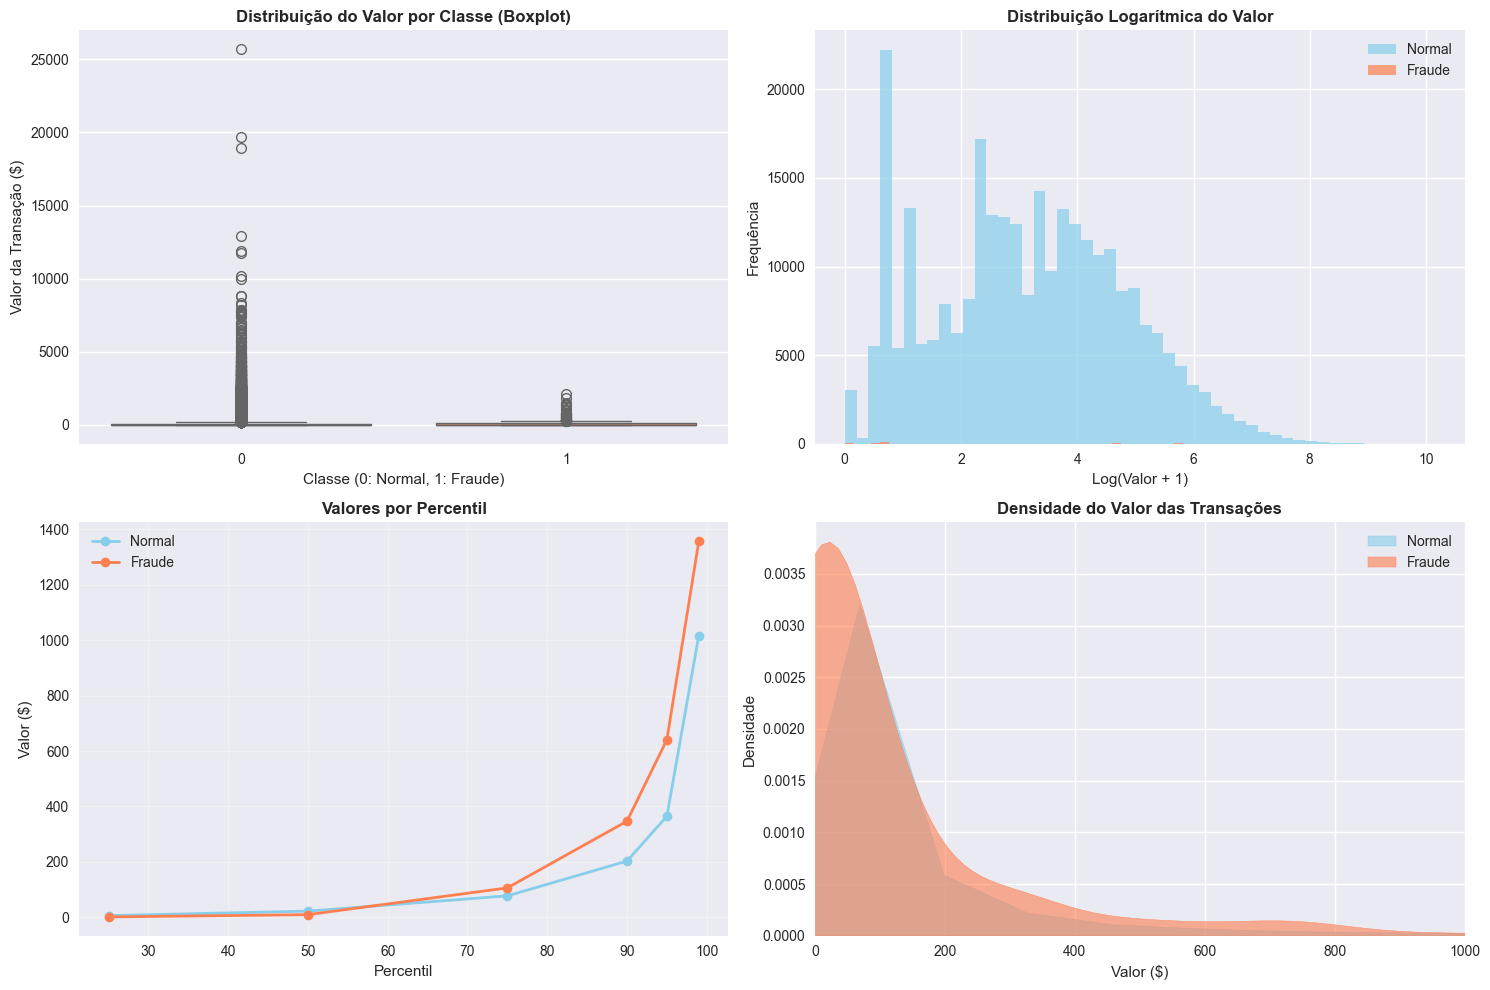


 **INSIGHTS:**
• Mediana das fraudes ($9.25) é menor que a mediana das transações normais ($22.00)
• 75% das fraudes têm valor ≤ $105.89
• Presença de outliers justifica uso de escalonadores robustos


In [5]:
# Célula 5: Análise Detalhada do Valor das Transações
def analyze_transaction_amounts(df):
    """Analisa a distribuição dos valores das transações por classe"""
    
    print("=" * 50)
    print("ANÁLISE DOS VALORES DAS TRANSAÇÕES (AMOUNT)")
    print("=" * 50)
    
    # Separar por classe
    normal_amounts = df[df['Class'] == 0]['Amount']
    fraud_amounts = df[df['Class'] == 1]['Amount']
    
    # Estatísticas descritivas
    print("\n **ESTATÍSTICAS DESCRITIVAS - VALOR DAS TRANSAÇÕES:**")
    
    stats_normal = normal_amounts.describe()
    stats_fraud = fraud_amounts.describe()
    
    print("\n **TRANSAÇÕES NORMAIS:**")
    print(f"• Média: ${stats_normal['mean']:.2f}")
    print(f"• Mediana: ${stats_normal['50%']:.2f}")
    print(f"• Desvio Padrão: ${stats_normal['std']:.2f}")
    print(f"• Mínimo: ${stats_normal['min']:.2f}")
    print(f"• Máximo: ${stats_normal['max']:.2f}")
    
    print("\n **TRANSAÇÕES FRAUDULENTAS:**")
    print(f"• Média: ${stats_fraud['mean']:.2f}")
    print(f"• Mediana: ${stats_fraud['50%']:.2f}")
    print(f"• Desvio Padrão: ${stats_fraud['std']:.2f}")
    print(f"• Mínimo: ${stats_fraud['min']:.2f}")
    print(f"• Máximo: ${stats_fraud['max']:.2f}")
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Boxplot
    sns.boxplot(data=df, x='Class', y='Amount', ax=axes[0,0], palette=['skyblue', 'coral'])
    axes[0,0].set_title('Distribuição do Valor por Classe (Boxplot)', fontweight='bold')
    axes[0,0].set_xlabel('Classe (0: Normal, 1: Fraude)')
    axes[0,0].set_ylabel('Valor da Transação ($)')
    
    # Histograma (escala log para melhor visualização)
    for classe, color, label in zip([0, 1], ['skyblue', 'coral'], ['Normal', 'Fraude']):
        data = df[df['Class'] == classe]['Amount']
        # Adicionar 1 para evitar log(0)
        log_data = np.log1p(data)
        axes[0,1].hist(log_data, bins=50, alpha=0.7, color=color, label=label)
    
    axes[0,1].set_title('Distribuição Logarítmica do Valor', fontweight='bold')
    axes[0,1].set_xlabel('Log(Valor + 1)')
    axes[0,1].set_ylabel('Frequência')
    axes[0,1].legend()
    
    # Estatísticas por percentis
    percentis = [25, 50, 75, 90, 95, 99]
    normal_percentis = np.percentile(normal_amounts, percentis)
    fraud_percentis = np.percentile(fraud_amounts, percentis)
    
    percentil_df = pd.DataFrame({
        'Percentil': percentis,
        'Normal ($)': normal_percentis,
        'Fraude ($)': fraud_percentis
    })
    
    print("\n **COMPARAÇÃO POR PERCENTIS:**")
    print(percentil_df.round(2))
    
    # Gráfico de percentis
    axes[1,0].plot(percentis, normal_percentis, 'o-', label='Normal', color='skyblue', linewidth=2)
    axes[1,0].plot(percentis, fraud_percentis, 'o-', label='Fraude', color='coral', linewidth=2)
    axes[1,0].set_title('Valores por Percentil', fontweight='bold')
    axes[1,0].set_xlabel('Percentil')
    axes[1,0].set_ylabel('Valor ($)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Densidade
    for classe, color, label in zip([0, 1], ['skyblue', 'coral'], ['Normal', 'Fraude']):
        data = df[df['Class'] == classe]['Amount']
        sns.kdeplot(data, ax=axes[1,1], label=label, color=color, fill=True, alpha=0.6)
    
    axes[1,1].set_title('Densidade do Valor das Transações', fontweight='bold')
    axes[1,1].set_xlabel('Valor ($)')
    axes[1,1].set_ylabel('Densidade')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 1000)  # Limitar para melhor visualização
    
    plt.tight_layout()
    plt.show()
    
    # Insights
    print("\n **INSIGHTS:**")
    print(f"• Mediana das fraudes (${stats_fraud['50%']:.2f}) é menor que a mediana das transações normais (${stats_normal['50%']:.2f})")
    print(f"• 75% das fraudes têm valor ≤ ${fraud_percentis[2]:.2f}")
    print("• Presença de outliers justifica uso de escalonadores robustos")
    
    return normal_amounts, fraud_amounts

# Executar análise
normal_amts, fraud_amts = analyze_transaction_amounts(df)

### Resumo Executivo e Próximos Passos

In [6]:
# Célula 6: Resumo Executivo e Próximos Passos
def executive_summary(df):
    """Fornece um resumo executivo da análise"""
    
    print("=" * 60)
    print(" RESUMO EXECUTIVO - FASE DE ENTENDIMENTO DOS DADOS")
    print("=" * 60)
    
    # Métricas principais
    total_transactions = len(df)
    fraud_count = df['Class'].sum()
    fraud_rate = (fraud_count / total_transactions) * 100
    
    avg_normal_amount = df[df['Class'] == 0]['Amount'].mean()
    avg_fraud_amount = df[df['Class'] == 1]['Amount'].mean()
    
    print(f"\n **MÉTRICAS PRINCIPAIS:**")
    print(f"• Total de transações: {total_transactions:,}")
    print(f"• Transações fraudulentas: {fraud_count:,} ({fraud_rate:.4f}%)")
    print(f"• Taxa de desbalanceamento: {(total_transactions - fraud_count) / fraud_count:.0f}:1")
    print(f"• Valor médio (normal): ${avg_normal_amount:.2f}")
    print(f"• Valor médio (fraude): ${avg_fraud_amount:.2f}")
    
    print(f"\n **CARACTERÍSTICAS TÉCNICAS:**")
    print(f"• Features disponíveis: {len(df.columns)}")
    print(f"• Features PCA (V1-V28): 28")
    print(f"• Features originais: Time, Amount, Class")
    
    print(f"\n  **DESAFIOS IDENTIFICADOS:**")
    print("1. Desbalanceamento extremo de classes (0.17% fraudes)")
    print("2. Necessidade de técnicas especiais de amostragem")
    print("3. Métrica de acurácia não é adequada")
    print("4. Presença de outliers na feature 'Amount'")
    
    print(f"\n **PRÓXIMOS PASSOS RECOMENDADOS:**")
    print("1. Pré-processamento: Escalonamento robusto de 'Amount' e 'Time'")
    print("2. Técnicas de reamostragem: SMOTE, ADASYN ou ajuste de pesos")
    print("3. Foco em métricas: Recall (prioridade) e Precision")
    print("4. Modelos: Random Forest, XGBoost com class weights")
    print("5. Validação: Stratified K-Fold Cross Validation")
    
    print(f"\n **METAS DE PERFORMANCE:**")
    print("• Recall (Detecção de fraudes): > 90%")
    print("• Precision (Minimizar falsos positivos): > 70%")
    print("• F2-Score (Balanceamento): > 80%")

# Executar resumo
executive_summary(df)

 RESUMO EXECUTIVO - FASE DE ENTENDIMENTO DOS DADOS

 **MÉTRICAS PRINCIPAIS:**
• Total de transações: 284,807
• Transações fraudulentas: 492 (0.1727%)
• Taxa de desbalanceamento: 578:1
• Valor médio (normal): $88.29
• Valor médio (fraude): $122.21

 **CARACTERÍSTICAS TÉCNICAS:**
• Features disponíveis: 31
• Features PCA (V1-V28): 28
• Features originais: Time, Amount, Class

  **DESAFIOS IDENTIFICADOS:**
1. Desbalanceamento extremo de classes (0.17% fraudes)
2. Necessidade de técnicas especiais de amostragem
3. Métrica de acurácia não é adequada
4. Presença de outliers na feature 'Amount'

 **PRÓXIMOS PASSOS RECOMENDADOS:**
1. Pré-processamento: Escalonamento robusto de 'Amount' e 'Time'
2. Técnicas de reamostragem: SMOTE, ADASYN ou ajuste de pesos
3. Foco em métricas: Recall (prioridade) e Precision
4. Modelos: Random Forest, XGBoost com class weights
5. Validação: Stratified K-Fold Cross Validation

 **METAS DE PERFORMANCE:**
• Recall (Detecção de fraudes): > 90%
• Precision (Minimiza